In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# To Scale our data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import r2_score


# hide warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
# reading the dataset
surp = pd.read_csv("Advanced_Regression/train.csv")
surp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#check missing percentage
percent_missing = (surp.isnull().sum() / surp.isnull().count()*100).sort_values(ascending = False)
percent_missing.head(15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
dtype: float64

In [6]:
# Dropping Columns with high missing values ,above 40%

surp.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)

In [7]:
surp[['LotFrontage','MasVnrArea','GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [8]:
#Treating missing values by imputing for columns with missing values less than or equal to 40%

surp['LotFrontage']= surp.LotFrontage.fillna(surp.LotFrontage.median()) 
surp['MasVnrArea']= surp.MasVnrArea.fillna(surp.MasVnrArea.median())
surp['GarageYrBlt']= surp.GarageYrBlt.fillna(surp.GarageYrBlt.mean())

<AxesSubplot:xlabel='GarageYrBlt', ylabel='Density'>

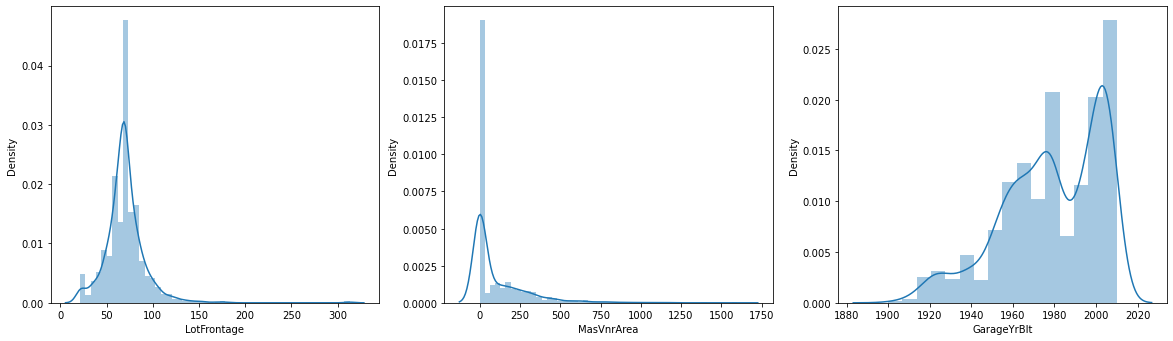

In [9]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.distplot(surp['LotFrontage'])
plt.subplot(2,3,2)
sns.distplot(surp['MasVnrArea'])
plt.subplot(2,3,3)
sns.distplot(surp['GarageYrBlt'])

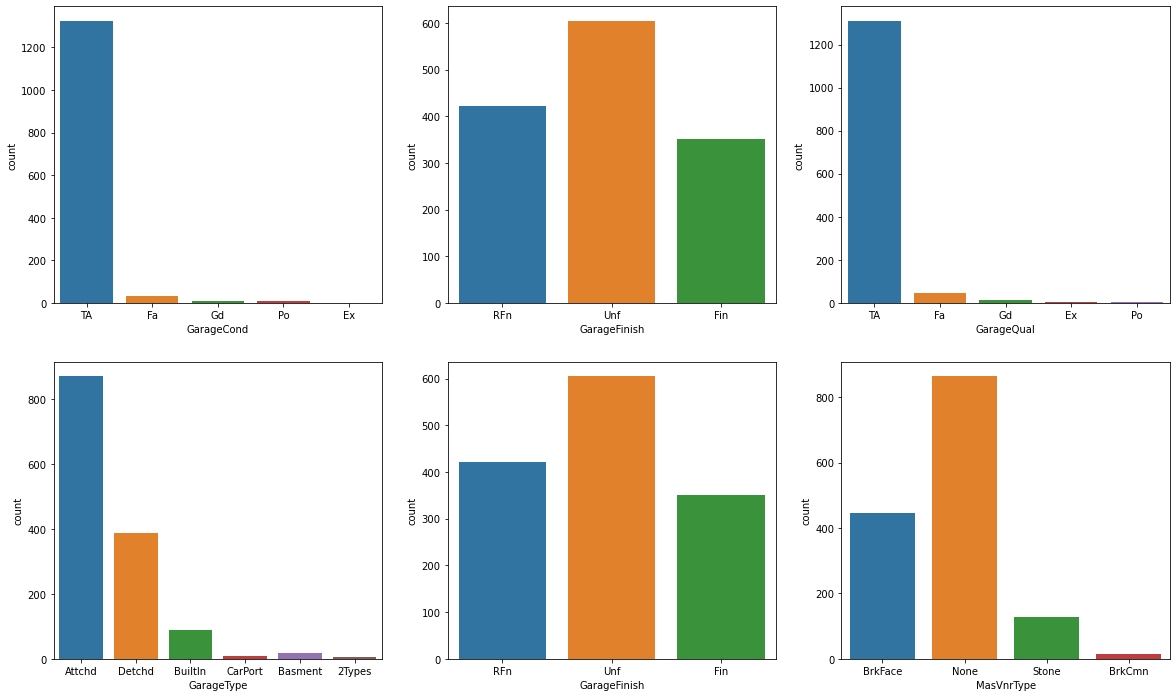

In [10]:
#Visualising the variables wih missing values

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'GarageCond', data = surp)

plt.subplot(2,3,2)
sns.countplot(x = 'GarageFinish',  data = surp)

plt.subplot(2,3,3)
sns.countplot(x = 'GarageQual', data = surp)
plt.subplot(2,3,4)
sns.countplot(x = 'GarageType', data = surp)
plt.subplot(2,3,5)
sns.countplot(x = 'GarageFinish',  data = surp)
plt.subplot(2,3,6)
sns.countplot(x = 'MasVnrType', data = surp)
plt.show()

In [11]:
# Cases when the house doesn't have the garrage so replacing null with No Garrage

surp['GarageType'] = surp['GarageType'].replace(np.nan, 'No Garage')
surp['GarageFinish'] = surp['GarageFinish'].replace(np.nan, 'No Garage')
surp['GarageCond'] = surp['GarageCond'].replace(np.nan, 'No Garage')
surp['GarageQual'] = surp['GarageQual'].replace(np.nan, 'No Garage')
surp['MasVnrType'] = surp['MasVnrType'].replace(np.nan, 'None') # replacing nan with the top option of this field
surp['Electrical'] = surp['Electrical'].replace(np.nan, 'SBrkr') # replacing nan with the top option of this field

In [12]:
#changing num to categorical so as to form these as dummy variables 
surp['MSSubClass']=surp['MSSubClass'].replace({20:'1-STORY 1946 & NEWER ALL STYLES',30:'1-STORY 1945 & OLDER',40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
       120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       150:'1-1/2 STORY PUD - ALL AGES',
       160:'2-STORY PUD - 1946 & NEWER',
       180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'})

surp['OverallQual']=surp['OverallQual'].replace({ 10:'Very Excellent',9:'Excellent',8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',3:'Fair',2:'Poor',1:'Very Poor'})
surp['OverallCond']=surp['OverallCond'].replace({ 10:'Very Excellent',9:'Excellent',8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',3:'Fair',2:'Poor',1:'Very Poor'})

In [13]:
surp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


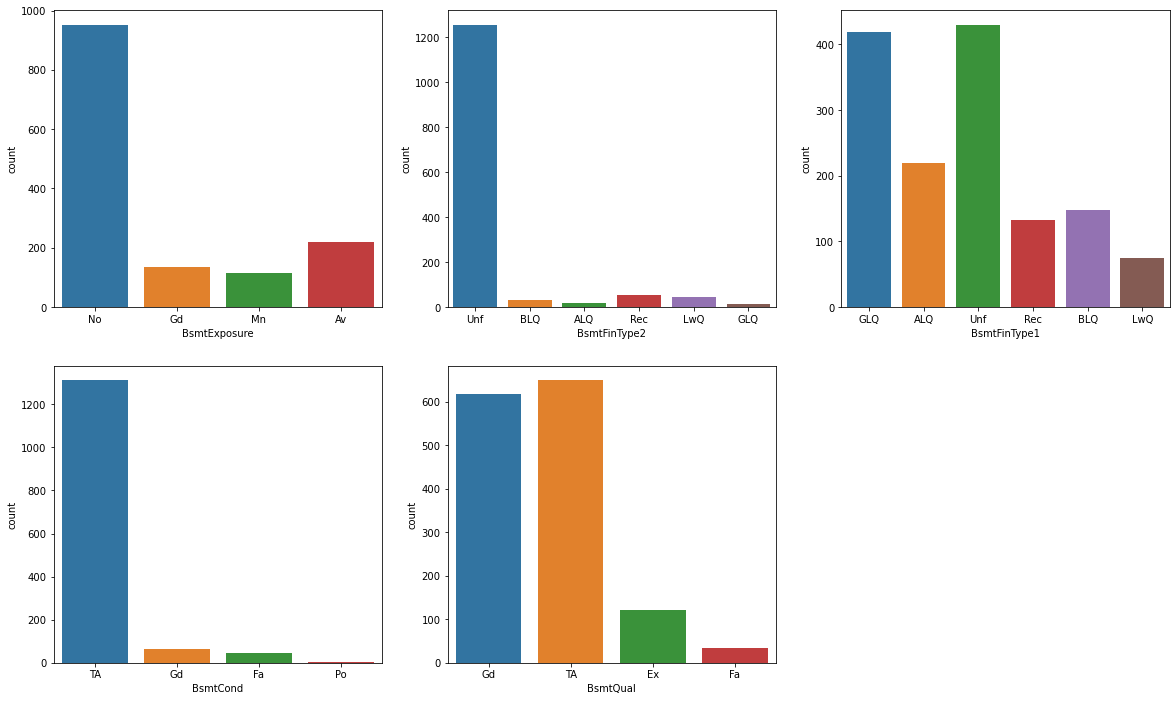

In [14]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'BsmtExposure', data = surp)

plt.subplot(2,3,2)
sns.countplot(x = 'BsmtFinType2',  data = surp)

plt.subplot(2,3,3)
sns.countplot(x = 'BsmtFinType1', data = surp)
plt.subplot(2,3,4)
sns.countplot(x = 'BsmtCond', data = surp)
plt.subplot(2,3,5)
sns.countplot(x = 'BsmtQual',  data = surp)

plt.show()

In [15]:
# Cases when the house doesn't have the basement so replacing null with No Basement

surp['BsmtExposure'] = surp['BsmtExposure'].replace(np.nan, 'No Basement')
surp['BsmtFinType2'] = surp['BsmtFinType2'].replace(np.nan, 'No Basement')
surp['BsmtFinType1'] = surp['BsmtFinType1'].replace(np.nan, 'No Basement')
surp['BsmtCond'] = surp['BsmtCond'].replace(np.nan, 'No Basement')
surp['BsmtQual'] = surp['BsmtQual'].replace(np.nan, 'No Basement')

In [16]:
#check missing percentage
percent_missing = (surp.isnull().sum() / surp.isnull().count()*100).sort_values(ascending = False)
percent_missing.head(10)

Id              0.0
FullBath        0.0
Fireplaces      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
KitchenAbvGr    0.0
BedroomAbvGr    0.0
HalfBath        0.0
BsmtHalfBath    0.0
dtype: float64

In [17]:
#Let's check the dependent variable i.e SalePrice

#descriptive statistics summary
surp['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

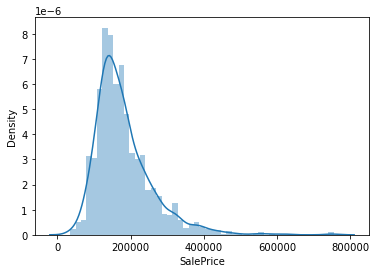

In [18]:
sns.distplot(surp['SalePrice']) #it's skewed 

In [19]:
#tranforming the SalePrice column to a normal disribution
surp['SalePrice']=np.log(surp.SalePrice)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

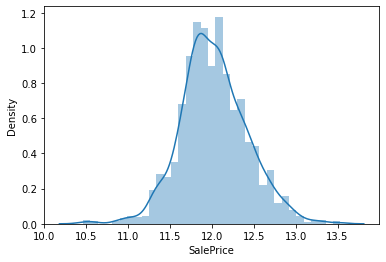

In [20]:
sns.distplot(surp['SalePrice'])

In [21]:
# Exploratory Data Analysis

Cat = surp.select_dtypes(include=['object'])
Cat.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

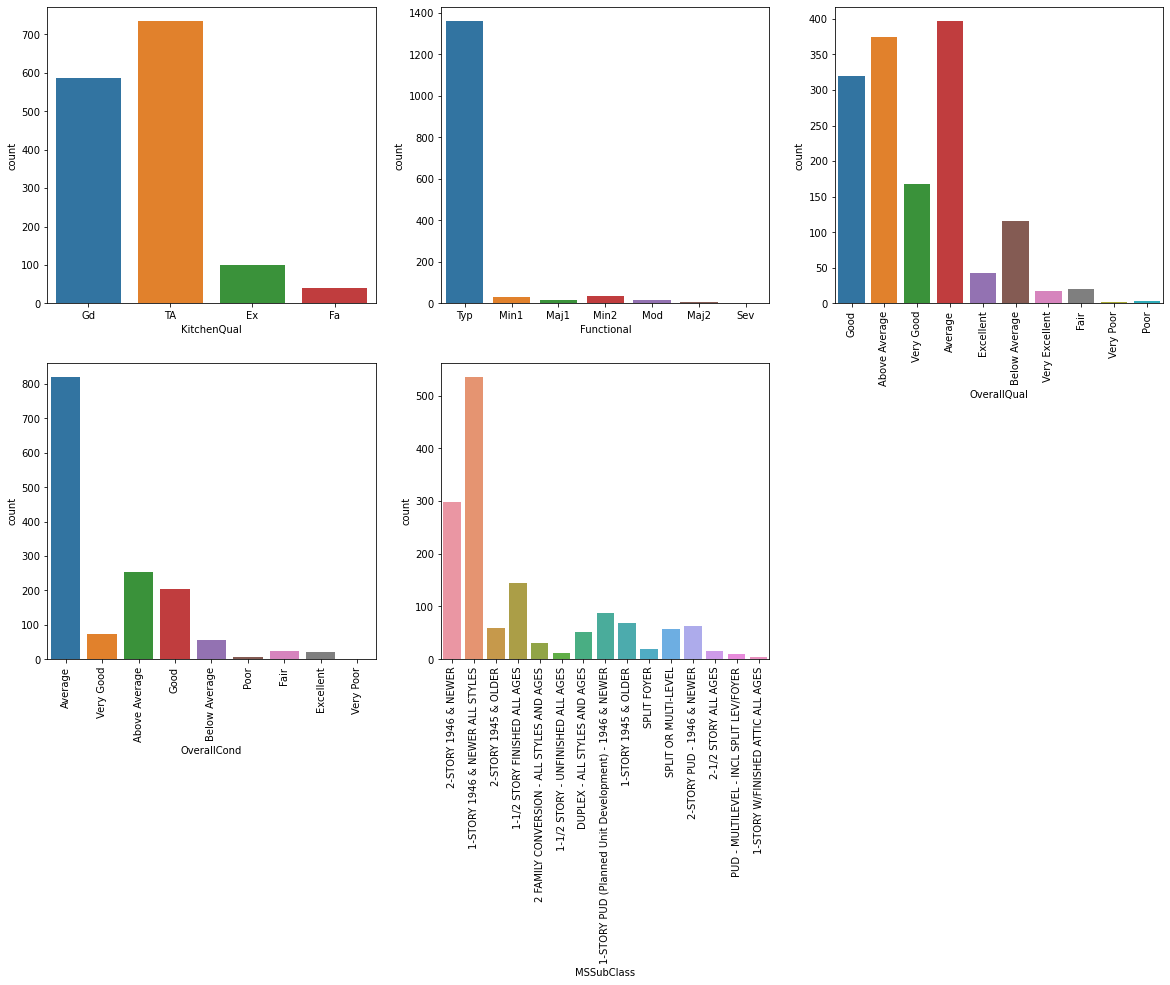

In [22]:
# Create two graphs to understand firstly the countplot and secondaly effect of that variable on dependent variable i.e. SalePrice

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'KitchenQual',  data = surp)
plt.subplot(2,3,2)
sns.countplot(x = 'Functional', data = surp)
plt.subplot(2,3,3)
sns.countplot(x = 'OverallQual', data = surp)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = 'OverallCond', data = surp)
plt.xticks(rotation=90)

plt.subplot(2,3,5)
sns.countplot(x = 'MSSubClass',  data = surp)
plt.xticks(rotation=90)


plt.show()

In [23]:
surp['MSSubClass'].value_counts()

1-STORY 1946 & NEWER ALL STYLES                          536
2-STORY 1946 & NEWER                                     299
1-1/2 STORY FINISHED ALL AGES                            144
1-STORY PUD (Planned Unit Development) - 1946 & NEWER     87
1-STORY 1945 & OLDER                                      69
2-STORY PUD - 1946 & NEWER                                63
2-STORY 1945 & OLDER                                      60
SPLIT OR MULTI-LEVEL                                      58
DUPLEX - ALL STYLES AND AGES                              52
2 FAMILY CONVERSION - ALL STYLES AND AGES                 30
SPLIT FOYER                                               20
2-1/2 STORY ALL AGES                                      16
1-1/2 STORY - UNFINISHED ALL AGES                         12
PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   10
1-STORY W/FINISHED ATTIC ALL AGES                          4
Name: MSSubClass, dtype: int64

In [24]:
# Dropping highly skewed column 
surp.drop(['Functional'],axis=1,inplace=True)

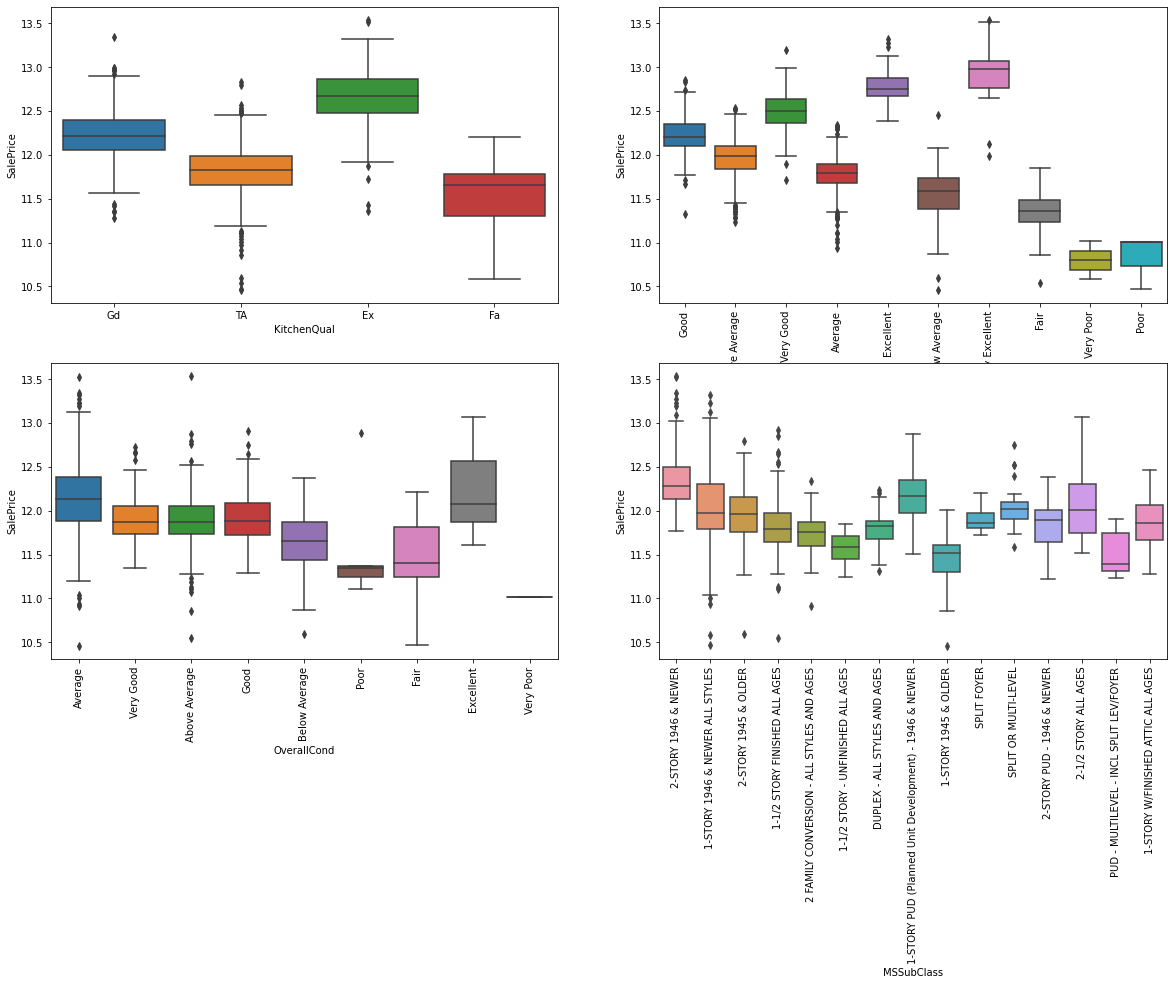

In [25]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x ='KitchenQual', y ='SalePrice', data = surp)
plt.subplot(2,2,2)
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = surp)
plt.xticks(rotation=90)

plt.subplot(2,2,3)
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data = surp)
plt.xticks(rotation=90)

plt.subplot(2,2,4)
sns.boxplot(x = 'MSSubClass', y = 'SalePrice', data = surp)
plt.xticks(rotation=90)

plt.show()

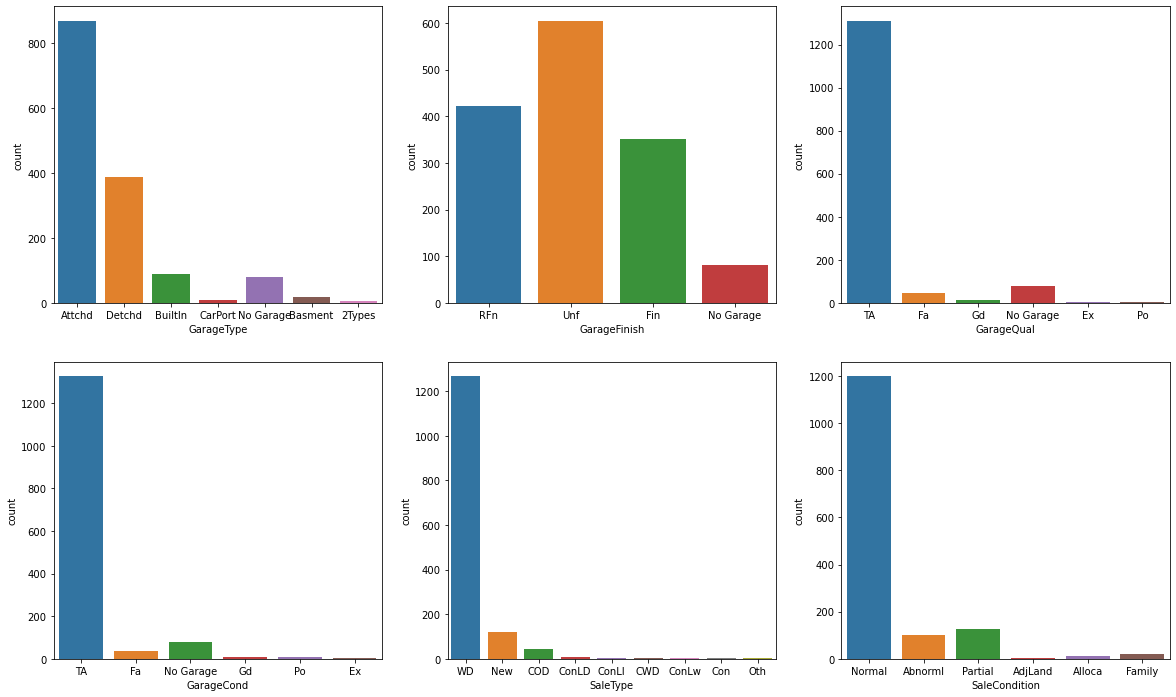

In [26]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'GarageType',  data = surp)
plt.subplot(2,3,2)
sns.countplot(x = 'GarageFinish', data = surp)
plt.subplot(2,3,3)
sns.countplot(x = 'GarageQual', data = surp)
plt.subplot(2,3,4)
sns.countplot(x = 'GarageCond', data = surp)
plt.subplot(2,3,5)
sns.countplot(x = 'SaleType',  data = surp)
plt.subplot(2,3,6)
sns.countplot(x = 'SaleCondition', data = surp)
plt.show()

In [27]:
surp['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [28]:
# We can see that in this group except GarageType and Garage Finsih almost all are skewed so we can drop these columns.

surp['GarageType'] = surp['GarageType'].replace(['Basment','CarPort','2Types'],'Others')
surp['SaleCondition'] = surp['SaleCondition'].replace(['Family','Alloca','AdjLand'],'Others')



# Dropping highly skewed column 
surp.drop(['GarageQual','GarageCond','SaleType'],axis=1,inplace=True)

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

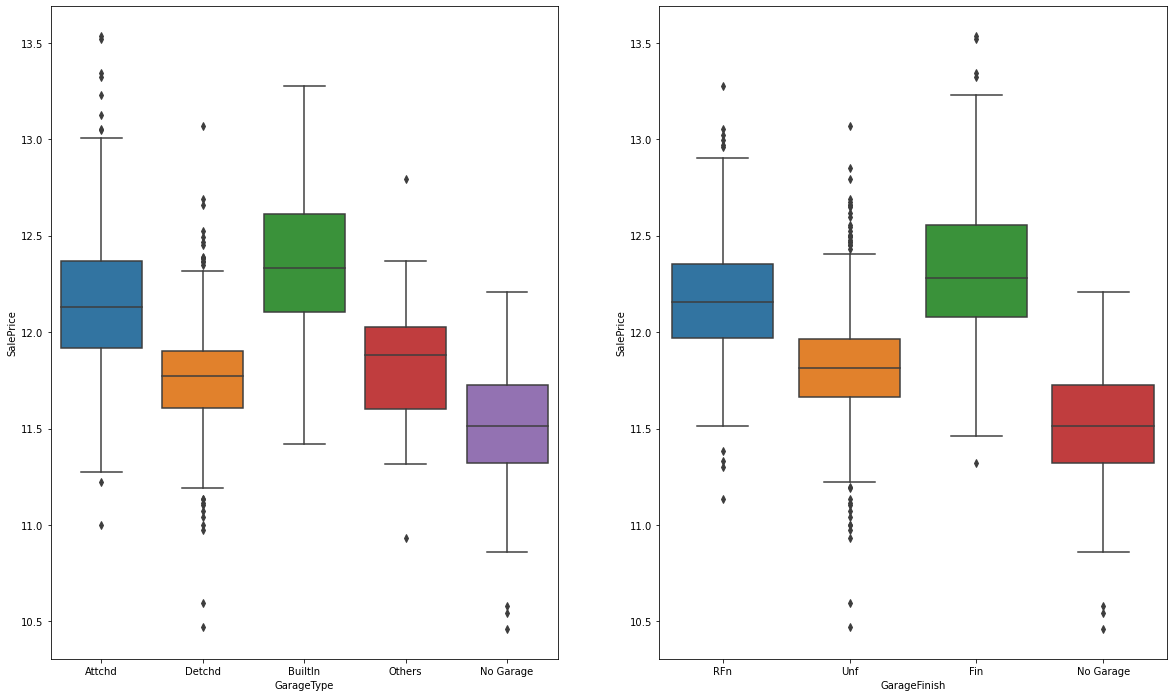

In [29]:
#Let's see effect of Garage type and GarageFinish on SalePrice

plt.figure(figsize=(20, 12))
plt.subplot(1,2,1)
sns.boxplot(x = 'GarageType', y ='SalePrice', data = surp)
plt.subplot(1,2,2)
sns.boxplot(x = 'GarageFinish', y = 'SalePrice', data = surp)

Price of Builtin Garagetype and Finished garage is the highest.

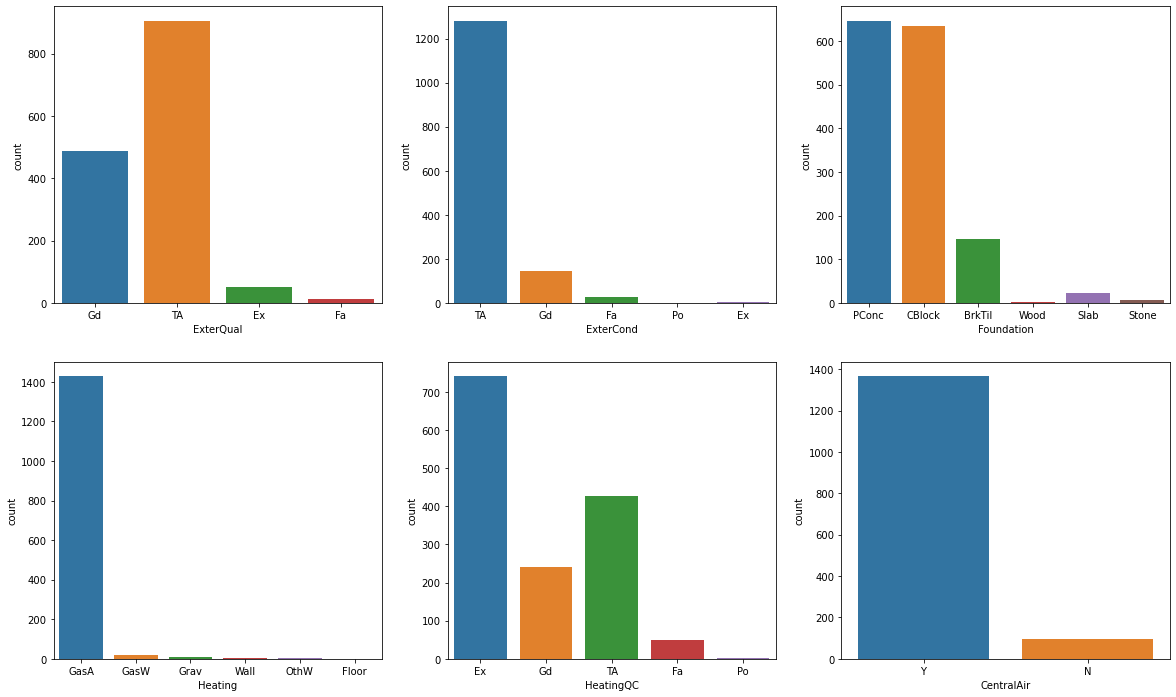

In [30]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'ExterQual',  data = surp)
plt.subplot(2,3,2)
sns.countplot(x = 'ExterCond', data = surp)
plt.subplot(2,3,3)
sns.countplot(x = 'Foundation', data = surp)
plt.subplot(2,3,4)
sns.countplot(x = 'Heating', data = surp)
plt.subplot(2,3,5)
sns.countplot(x = 'HeatingQC',  data = surp)
plt.subplot(2,3,6)
sns.countplot(x = 'CentralAir', data = surp)
plt.show()

Majority of ExterQual, ExerCond is TA.
Poured Contrete foundation are the highest in number.
Meanwhile variables like Heating , Central Airand Exter Cond are skewed so would be dropping these variables.

In [31]:
surp['Foundation'] = surp['Foundation'].replace(['Slab','Stone','Wood'],'Others')

# Dropping highly skewed column 
surp.drop(['CentralAir','Heating','ExterCond'],axis=1,inplace=True)

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

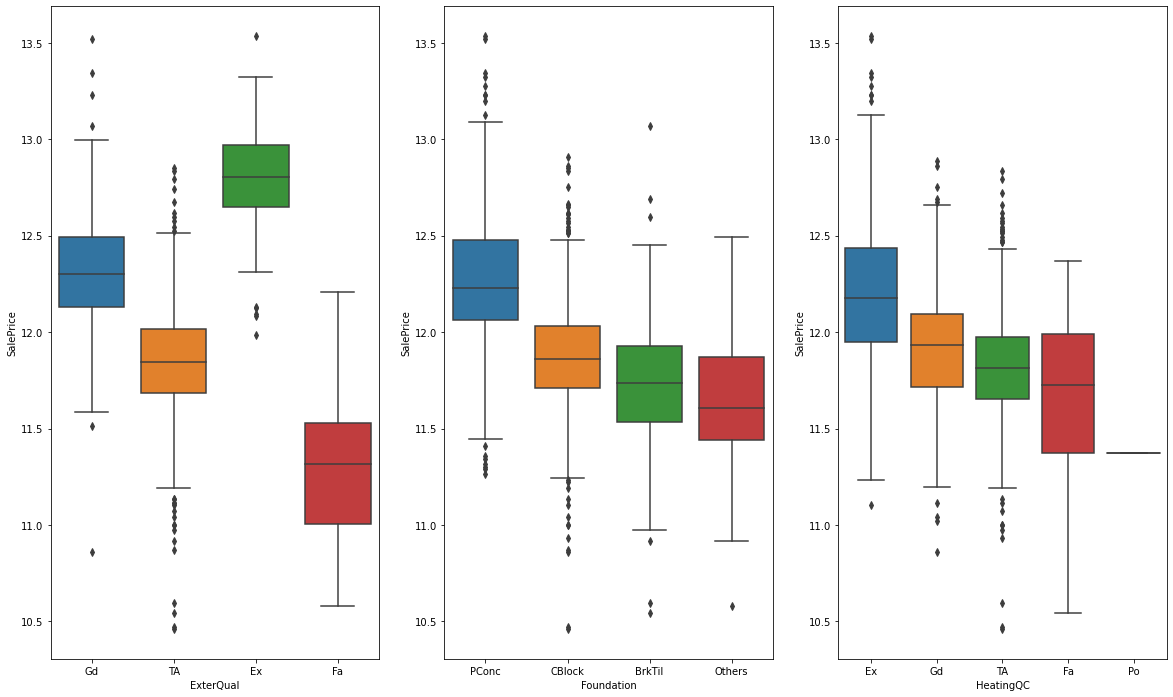

In [32]:
#Let's see effect of Garage type and GarageFinish on SalePrice

plt.figure(figsize=(20, 12))
plt.subplot(1,3,1)
sns.boxplot(x = 'ExterQual', y ='SalePrice', data = surp)
plt.subplot(1,3,2)
sns.boxplot(x = 'Foundation', y = 'SalePrice', data = surp)
plt.subplot(1,3,3)
sns.boxplot(x = 'HeatingQC', y = 'SalePrice', data = surp)

Price of Excellent ExterQual and HeatingQc is highest.
Price of Poured Contrete Foundation is highest.

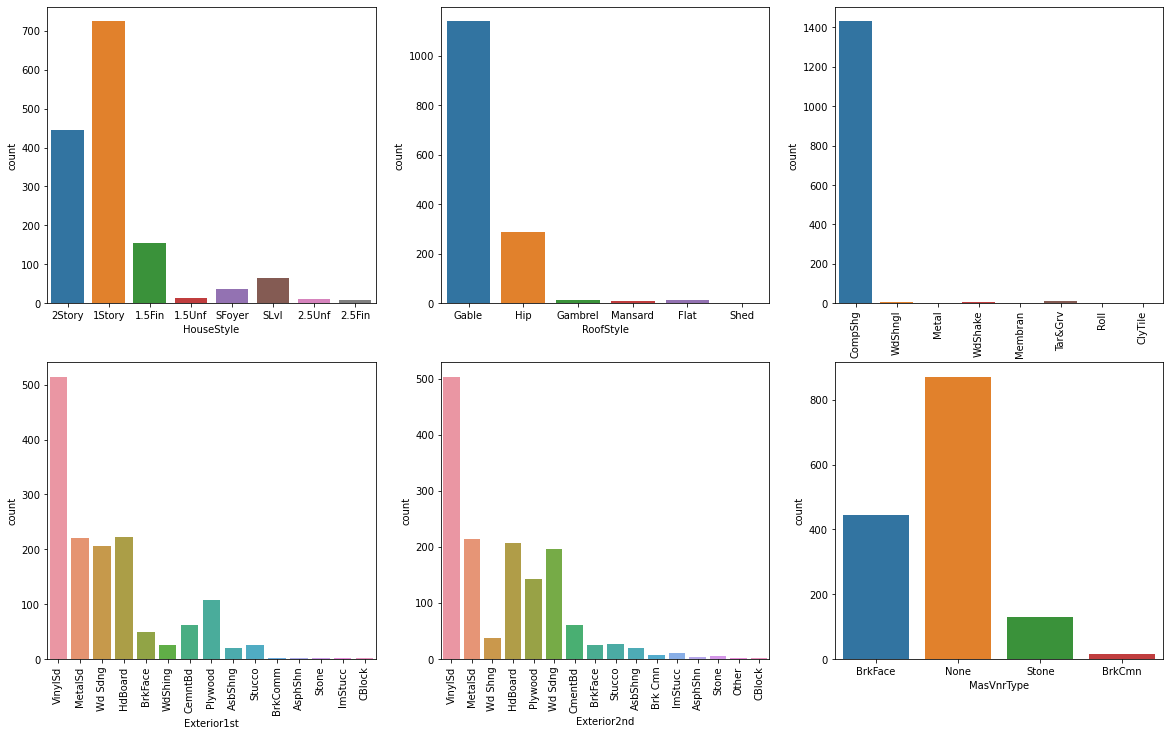

In [33]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'HouseStyle',  data = surp)
plt.subplot(2,3,2)
sns.countplot(x = 'RoofStyle', data = surp)
plt.subplot(2,3,3)
sns.countplot(x = 'RoofMatl', data = surp)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = 'Exterior1st', data = surp)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.countplot(x = 'Exterior2nd',  data = surp)
plt.xticks(rotation=90)
plt.subplot(2,3,6)
sns.countplot(x = 'MasVnrType', data = surp)
plt.show()

In [34]:
surp['HouseStyle'] = surp['HouseStyle'].replace(['SFoyer','1.5Unf','2.5Unf','2.5Fin'],'Others')
surp['RoofStyle'] = surp['RoofStyle'].replace(['Shed','Mansard','Gambrel','Flat'],'Others')
surp['Exterior1st'] = surp['Exterior1st'].replace(['AsphShn','ImStucc','CBlock','Stone','BrkComm','AsbShng','Stucco','WdShing'],'Others')
surp['Exterior2nd'] = surp['Exterior2nd'].replace(['Other','AsphShn','ImStucc','CBlock','Stone','BrkComm','AsbShng','Stucco','BrkFace'],'Others')

# Dropping highly skewed column 
surp.drop(['RoofMatl'],axis=1,inplace=True)

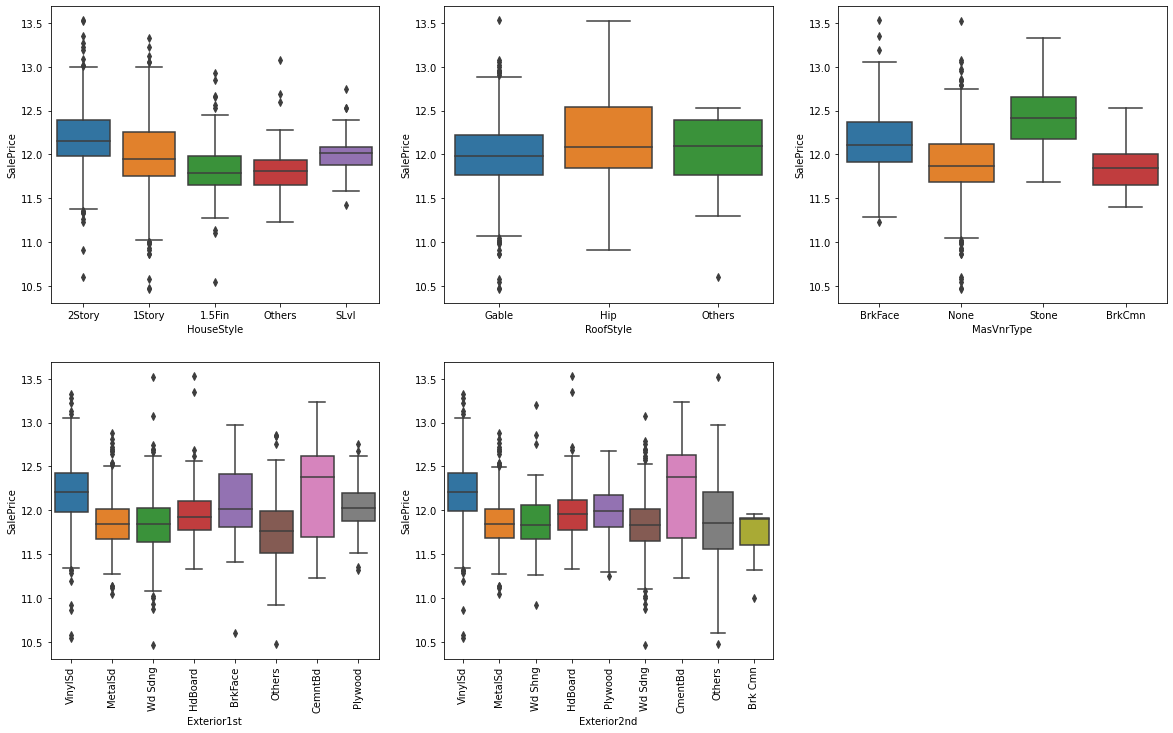

In [35]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'HouseStyle', y ='SalePrice', data = surp)
plt.subplot(2,3,2)
sns.boxplot(x = 'RoofStyle', y = 'SalePrice', data = surp)
plt.subplot(2,3,3)
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = surp)
plt.subplot(2,3,4)
sns.boxplot(x = 'Exterior1st', y = 'SalePrice', data = surp)
plt.xticks(rotation=90)
plt.subplot(2,3,5)
sns.boxplot(x = 'Exterior2nd', y = 'SalePrice', data = surp)
plt.xticks(rotation=90)
plt.show()

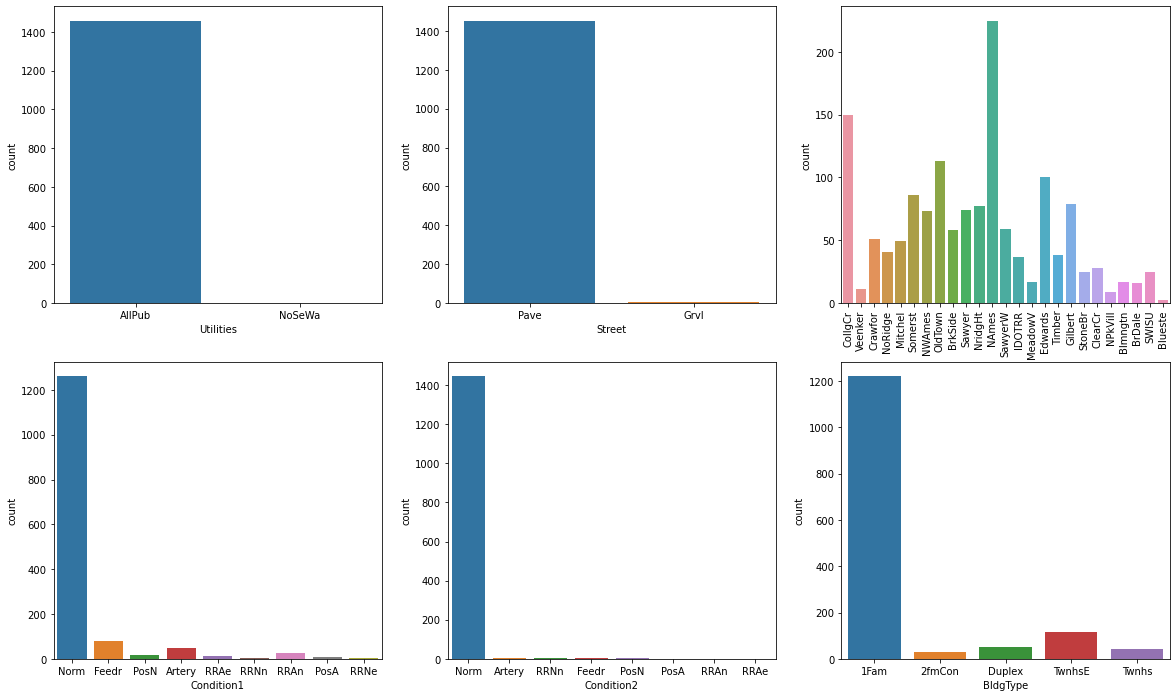

In [36]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'Utilities',  data = surp)
plt.subplot(2,3,2)
sns.countplot(x = 'Street', data = surp)
plt.subplot(2,3,3)
sns.countplot(x = 'Neighborhood', data = surp)
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.countplot(x = 'Condition1', data = surp)
plt.subplot(2,3,5)
sns.countplot(x = 'Condition2',  data = surp)
plt.subplot(2,3,6)
sns.countplot(x = 'BldgType', data = surp)
plt.show()

In [37]:
surp['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [38]:
# Dropping highly skewed column 
surp.drop(['Utilities','Street','Condition1','Condition2'],axis=1,inplace=True)

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

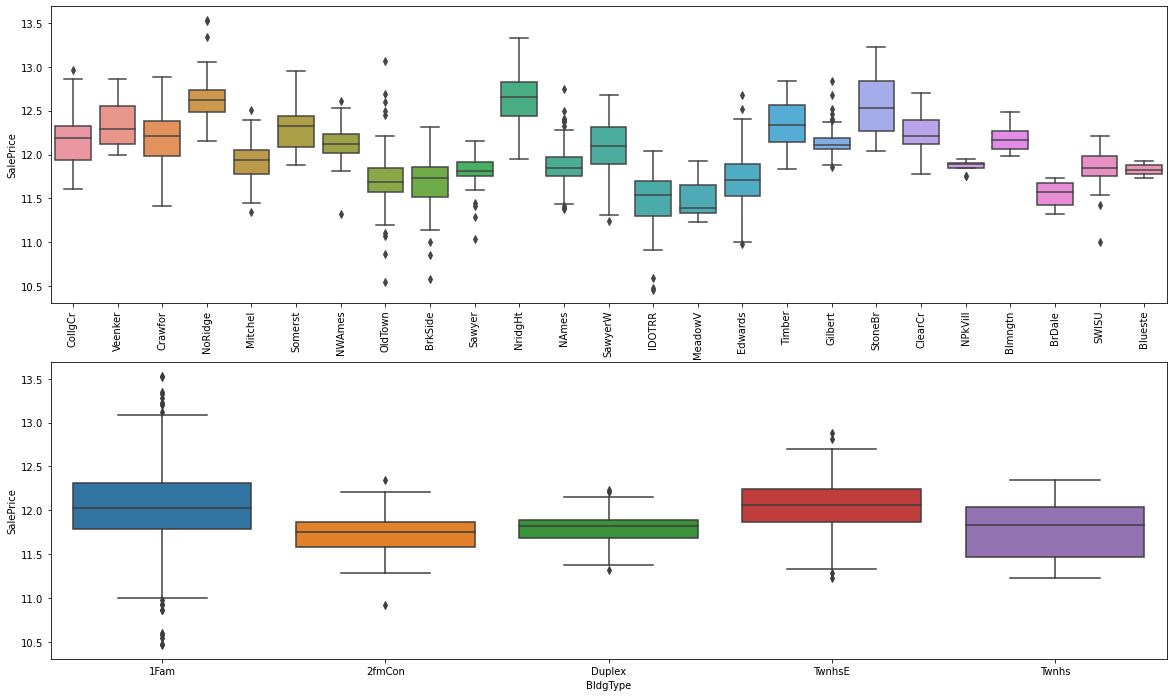

In [39]:
plt.figure(figsize=(20, 12))
plt.subplot(2,1,1)
sns.boxplot(x = 'Neighborhood', y ='SalePrice', data = surp)
plt.xticks(rotation=90)
plt.subplot(2,1,2)
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = surp)

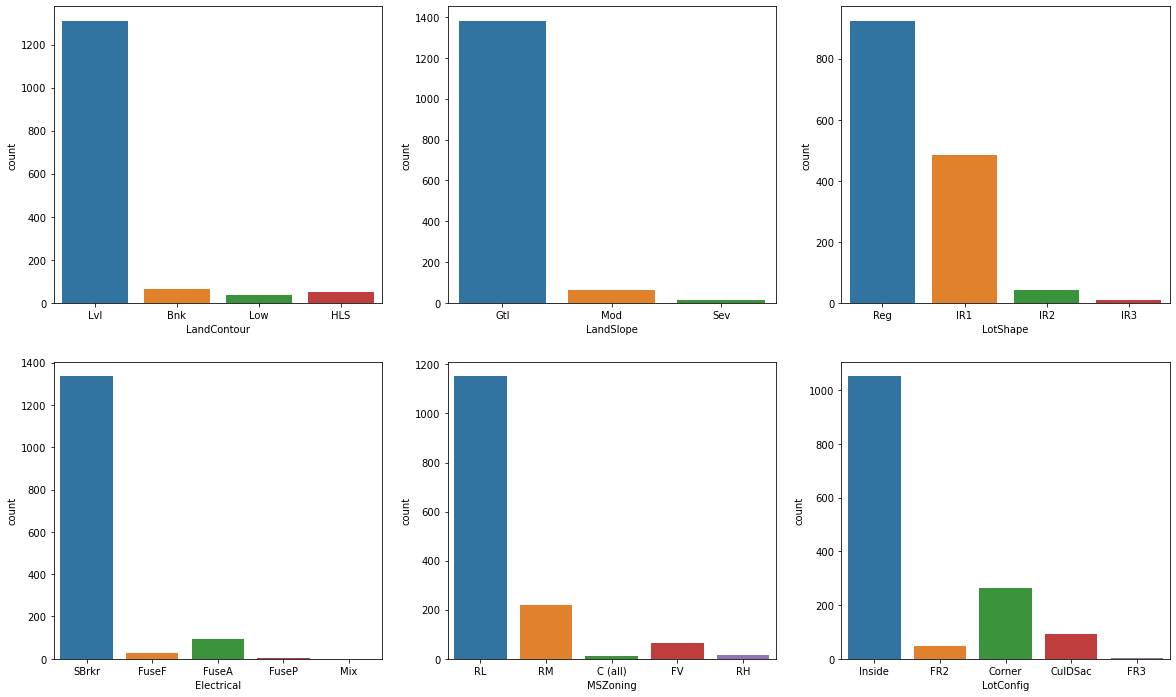

In [40]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'LandContour',  data = surp)
plt.subplot(2,3,2)
sns.countplot(x = 'LandSlope', data = surp)
plt.subplot(2,3,3)
sns.countplot(x = 'LotShape', data = surp)
plt.subplot(2,3,4)
sns.countplot(x = 'Electrical', data = surp)
plt.subplot(2,3,5)
sns.countplot(x = 'MSZoning',  data = surp)
plt.subplot(2,3,6)
sns.countplot(x = 'LotConfig', data = surp)
plt.show()

In [41]:
surp['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [42]:
surp.drop(['LandSlope','LandContour','Electrical'],axis=1,inplace=True)

surp['MSZoning'] = surp['MSZoning'].replace(['RH','C (all)'],'Others')

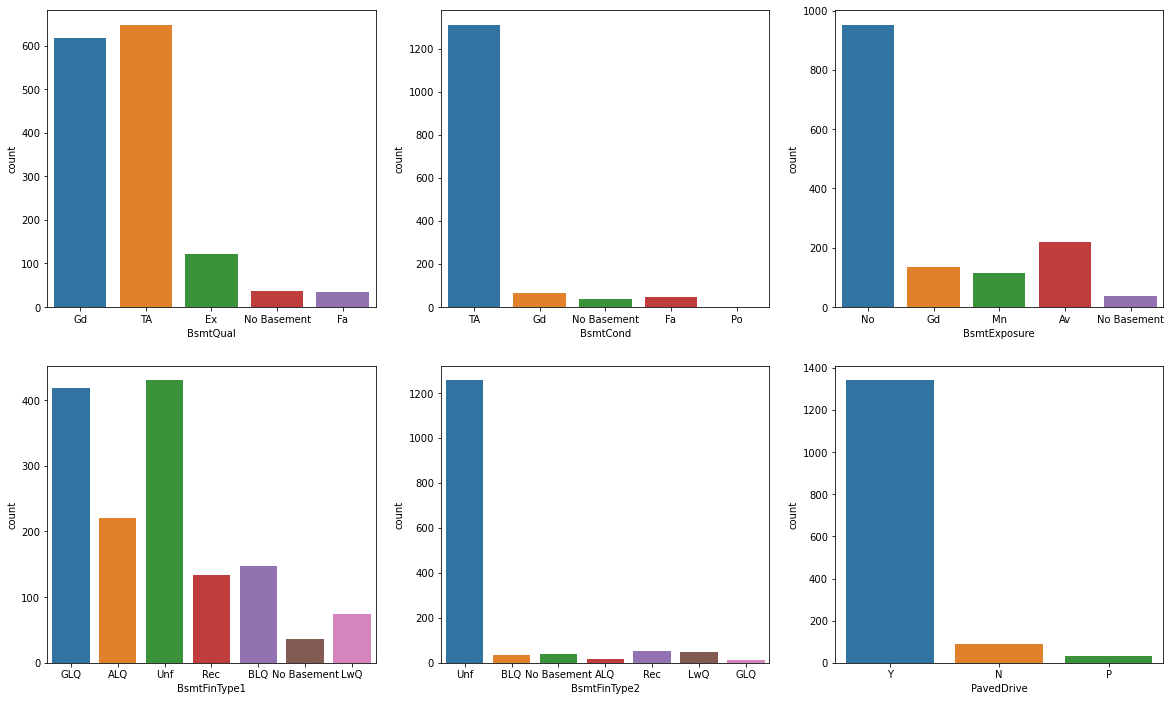

In [43]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'BsmtQual',  data = surp)
plt.subplot(2,3,2)
sns.countplot(x = 'BsmtCond', data = surp)
plt.subplot(2,3,3)
sns.countplot(x = 'BsmtExposure', data = surp)
plt.subplot(2,3,4)
sns.countplot(x = 'BsmtFinType1', data = surp)
plt.subplot(2,3,5)
sns.countplot(x = 'BsmtFinType2',  data = surp)
plt.subplot(2,3,6)
sns.countplot(x = 'PavedDrive', data = surp)
plt.show()

In [44]:
surp['BsmtCond'].value_counts()

TA             1311
Gd               65
Fa               45
No Basement      37
Po                2
Name: BsmtCond, dtype: int64

In [45]:
surp.drop(['BsmtFinType2','PavedDrive','BsmtCond'],axis=1,inplace=True)

In [46]:
surp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,1,2-STORY 1946 & NEWER,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,61,0,0,0,0,0,2,2008,Normal,12.247694
1,2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,0,0,0,0,0,0,5,2007,Normal,12.109011
2,3,2-STORY 1946 & NEWER,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,42,0,0,0,0,0,9,2008,Normal,12.317167
3,4,2-STORY 1945 & OLDER,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,35,272,0,0,0,0,2,2006,Abnorml,11.849398
4,5,2-STORY 1946 & NEWER,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,84,0,0,0,0,0,12,2008,Normal,12.429216


In [47]:
surp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   LotShape       1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   BldgType       1460 non-null   object 
 9   HouseStyle     1460 non-null   object 
 10  OverallQual    1460 non-null   object 
 11  OverallCond    1460 non-null   object 
 12  YearBuilt      1460 non-null   int64  
 13  YearRemodAdd   1460 non-null   int64  
 14  RoofStyle      1460 non-null   object 
 15  Exterior1st    1460 non-null   object 
 16  Exterior2nd    1460 non-null   object 
 17  MasVnrType     1460 non-null   object 
 18  MasVnrAr

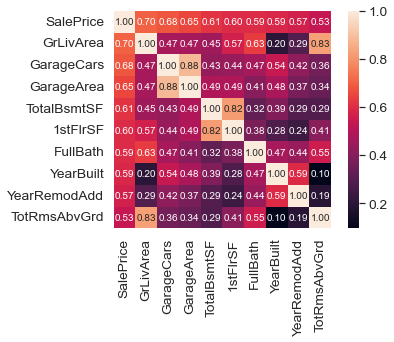

In [48]:
#saleprice correlation matrix
corrmat = surp.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(surp[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [49]:
surp['YearSinceRemodel'] = 2010 - ((surp['YearRemodAdd'] - surp['YearBuilt']) + surp['YearBuilt'])

In [50]:
Cat1 = surp.select_dtypes(include=['object']) #checking all categorical columns to form dummy variables
Cat1.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual',
       'GarageType', 'GarageFinish', 'SaleCondition'],
      dtype='object')

In [51]:
Num = surp.select_dtypes(include=['int64','float64']) #all numerical variables
Num.columns

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
       'YearSinceRemodel'],
      dtype='object')

In [52]:
Num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1460 non-null   int64  
 1   LotFrontage       1460 non-null   float64
 2   LotArea           1460 non-null   int64  
 3   YearBuilt         1460 non-null   int64  
 4   YearRemodAdd      1460 non-null   int64  
 5   MasVnrArea        1460 non-null   float64
 6   BsmtFinSF1        1460 non-null   int64  
 7   BsmtFinSF2        1460 non-null   int64  
 8   BsmtUnfSF         1460 non-null   int64  
 9   TotalBsmtSF       1460 non-null   int64  
 10  1stFlrSF          1460 non-null   int64  
 11  2ndFlrSF          1460 non-null   int64  
 12  LowQualFinSF      1460 non-null   int64  
 13  GrLivArea         1460 non-null   int64  
 14  BsmtFullBath      1460 non-null   int64  
 15  BsmtHalfBath      1460 non-null   int64  
 16  FullBath          1460 non-null   int64  


In [53]:
# Dummy Variables

Cat1 = pd.get_dummies(Cat1,drop_first=True)
print(Cat1.shape)

(1460, 130)


In [54]:
Cat1.head()

,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_No Garage,GarageType_Others,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0


In [55]:
# concat dummy variables with main dataset
surp = pd.concat([surp, Cat1], axis=1) 

In [56]:
surp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_No Garage,GarageType_Others,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,1,2-STORY 1946 & NEWER,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,0,0,0,0,0,1,0,1,0,0
1,2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,0,0,0,0,0,1,0,1,0,0
2,3,2-STORY 1946 & NEWER,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,0,0,0,0,0,1,0,1,0,0
3,4,2-STORY 1945 & OLDER,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,0,1,0,0,0,0,1,0,0,0
4,5,2-STORY 1946 & NEWER,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,0,0,0,0,0,1,0,1,0,0


In [57]:
surp.drop(['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish',
       'SaleCondition','Id','OverallCond','MSSubClass','OverallQual'],axis=1,inplace=True)

In [58]:
surp.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_No Garage,GarageType_Others,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,0,0,1,0,1,0,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,0,0,1,0,1,0,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,0,0,1,0,1,0,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,1,0,0,0,0,1,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,0,0,1,0,1,0,0


In [59]:

surp.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis=1,inplace=True)

In [60]:
surp.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_No Garage,GarageType_Others,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,0,0,0,0,0,1,0,1,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,0,0,0,0,0,1,0,1,0,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,0,0,0,0,0,1,0,1,0,0
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,0,1,0,0,0,0,1,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,0,0,0,0,0,1,0,1,0,0


In [61]:
# Putting feature variable to X
X = surp.drop(['SalePrice'], axis=1)

X.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_No Garage,GarageType_Others,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,0,0,0,0,0,1,0,1,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,0,0,0,0,0,1,0,1,0,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,0,0,0,0,0,1,0,1,0,0
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,0,1,0,0,0,0,1,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,0,0,0,0,0,1,0,1,0,0


In [62]:
# Putting response variable to y
y = surp['SalePrice']

y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [63]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [64]:
scaler = StandardScaler()

X_train[['LotFrontage', 'LotArea','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces','GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']] = scaler.fit_transform(X_train[['LotFrontage', 'LotArea','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces','GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']])

X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_No Garage,GarageType_Others,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
210,-0.115302,-0.473765,-0.558025,0.043512,-0.293313,-0.374367,-0.430911,-0.765065,-0.787597,-0.124502,...,0,0,1,0,1,0,0,1,0,0
318,0.926898,-0.056845,0.809137,1.160345,-0.293313,-0.454644,0.621579,0.511914,2.140556,-0.124502,...,0,0,0,0,0,1,0,1,0,0
239,-0.794998,-0.169324,-0.558025,-0.761296,-0.293313,0.171964,-0.712011,-0.930972,0.795996,-0.124502,...,0,1,0,0,0,0,1,1,0,0
986,-0.477806,-0.502297,-0.558025,-0.963574,-0.293313,-0.175904,-1.256778,-0.420683,0.669584,-0.124502,...,0,0,0,0,0,0,1,1,0,0
1416,-0.432493,0.082905,-0.558025,-0.963574,-0.293313,0.475233,-0.620490,0.195183,1.611926,-0.124502,...,0,1,0,0,0,0,1,1,0,0


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

#### Model Building and Evaluation

Ridge and Lasso Regression

In [66]:
# Ridge

# list of alphas to tune
params = {'alpha': [0.00004,0.0001, 0.001, 0.01, 0.1, 10,100,1000]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [4e-05, 0.0001, 0.001, 0.01, 0.1, 10, 100,
                                   1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [67]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=100]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014348,0.009646,0.004435,0.000231,0.00004,{'alpha': 4e-05},0.868246,0.777081,0.838201,0.890474,...,0.853287,0.042834,5,0.924369,0.935767,0.931027,0.919954,0.918905,0.926004,0.006484
1,0.008807,0.000392,0.004340,0.000375,0.0001,{'alpha': 0.0001},0.868247,0.777081,0.838201,0.890476,...,0.853288,0.042836,4,0.924369,0.935767,0.931027,0.919954,0.918905,0.926004,0.006484
2,0.011539,0.003922,0.006960,0.003331,0.001,{'alpha': 0.001},0.868258,0.777072,0.838200,0.890516,...,0.853309,0.042858,3,0.924369,0.935767,0.931027,0.919954,0.918905,0.926004,0.006484
3,0.013569,0.001498,0.006700,0.001166,0.01,{'alpha': 0.01},0.868367,0.776981,0.838188,0.890866,...,0.853502,0.043071,2,0.924368,0.935766,0.931026,0.919953,0.918902,0.926003,0.006484
4,0.011173,0.003743,0.006139,0.001984,0.1,{'alpha': 0.1},0.869382,0.776055,0.838034,0.892791,...,0.854768,0.044649,1,0.924329,0.935711,0.930967,0.919904,0.918744,0.925931,0.006505


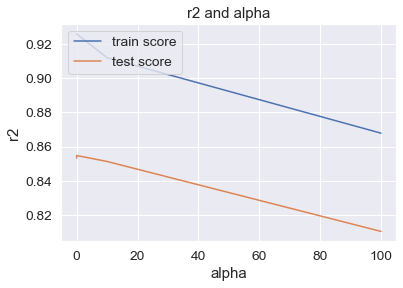

In [68]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [69]:
#optimum alpha

alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-4.74809780e-04,  1.59466646e-06,  6.17112057e-06,  3.73538624e-06,
        1.15081437e-05,  1.82053056e-05,  3.34488367e-05,  7.92009096e-05,
        1.09011751e-04, -7.70408569e-05,  1.11171801e-04,  4.25420135e-02,
        1.51319614e-02,  5.09516505e-02,  3.69272171e-02,  9.07794039e-03,
       -8.12648652e-02,  8.30696546e-03,  3.96097675e-02,  5.34751466e-02,
        3.43279188e-05,  9.90267283e-05, -5.47707192e-05,  1.22380757e-04,
        1.94886076e-04,  2.27453067e-04, -4.04142867e-04, -3.68907754e-06,
        5.21312292e-04, -1.59513446e-03,  1.22746032e-02, -8.43053932e-02,
        4.98263439e-02,  5.96932189e-03,  1.37128949e-04, -1.20780328e-02,
        2.35023365e-02,  2.51877006e-02, -1.48351396e-05, -4.06689958e-02,
        1.48370219e-02, -2.89980792e-02,  2.13765700e-02,  9.23512984e-03,
       -7.75969900e-02,  1.25978119e-02, -2.93034632e-02,  2.18691748e-02,
       -4.94699235e-02,  7.41424037e-03,  3.66405387e-02, -3.24003086e-02,
       -1.39715714e-02, -

In [70]:
ridge.score(X_train,y_train)

0.9092068605070027

In [71]:
ridge.score(X_test,y_test)

0.8744204967072813

In [72]:
# Ridge model parameters
model_parameters = list(sorted(ridge.coef_))
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 11.541),
 ('LotFrontage', -0.143),
 ('LotArea', -0.091),
 ('MasVnrArea', -0.084),
 ('BsmtFinSF1', -0.084),
 ('BsmtFinSF2', -0.082),
 ('BsmtUnfSF', -0.081),
 ('TotalBsmtSF', -0.078),
 ('1stFlrSF', -0.069),
 ('2ndFlrSF', -0.066),
 ('LowQualFinSF', -0.066),
 ('GrLivArea', -0.064),
 ('BsmtFullBath', -0.062),
 ('BsmtHalfBath', -0.06),
 ('FullBath', -0.055),
 ('HalfBath', -0.054),
 ('BedroomAbvGr', -0.052),
 ('KitchenAbvGr', -0.052),
 ('TotRmsAbvGrd', -0.052),
 ('Fireplaces', -0.052),
 ('GarageCars', -0.051),
 ('GarageArea', -0.051),
 ('WoodDeckSF', -0.051),
 ('OpenPorchSF', -0.05),
 ('EnclosedPorch', -0.049),
 ('3SsnPorch', -0.048),
 ('ScreenPorch', -0.048),
 ('PoolArea', -0.046),
 ('MiscVal', -0.042),
 ('MoSold', -0.041),
 ('YearSinceRemodel', -0.033),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.032),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.032),
 ('MSSubClass_1-STORY 1946 & NEWER ALL STYLES', -0.032),
 ('MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER',

In [73]:
# Lasso

params = {'alpha': [0.00006,0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008 ]}
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [6e-05, 0.0006, 0.0008, 0.001, 0.002, 0.004,
                                   0.006, 0.008]},
             return_train_score=True, scoring='r2', verbose=1)

In [74]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.143152,0.088316,0.005131,0.002649,0.00006,{'alpha': 6e-05},0.872325,0.773018,0.839580,0.895919,...,0.856191,0.046822,1,0.923862,0.935108,0.930417,0.919443,0.917980,0.925362,0.006517
1,0.016028,0.002640,0.002759,0.000067,0.0006,{'alpha': 0.0006},0.884401,0.724748,0.835348,0.898012,...,0.850393,0.067713,2,0.911534,0.923960,0.918723,0.907989,0.903086,0.913058,0.007462
2,0.016715,0.002507,0.002872,0.000302,0.0008,{'alpha': 0.0008},0.883902,0.709901,0.832624,0.895453,...,0.845629,0.072409,3,0.906265,0.920044,0.913821,0.903300,0.897012,0.908088,0.008059
3,0.016296,0.002603,0.003306,0.000679,0.001,{'alpha': 0.001},0.883078,0.699448,0.827873,0.892849,...,0.841339,0.075588,4,0.901000,0.916719,0.909043,0.898351,0.892075,0.903438,0.008588
4,0.009550,0.000514,0.002641,0.000065,0.002,{'alpha': 0.002},0.877497,0.652922,0.806379,0.884122,...,0.821178,0.089143,5,0.881651,0.901967,0.888512,0.880169,0.871710,0.884802,0.010111


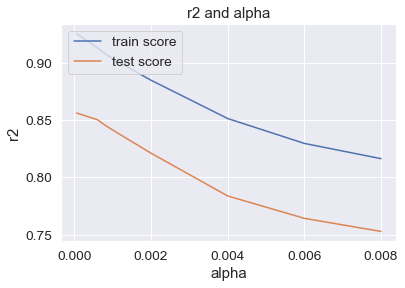

In [75]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')

plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [76]:
#optimum alpha

alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [77]:
lasso.coef_

array([-4.09356126e-04,  1.41043514e-06,  1.80666838e-05,  4.75861642e-05,
        4.91108947e-05,  5.55828023e-05,  3.22848128e-05,  1.72776225e-04,
        1.95176491e-04, -2.93129965e-05,  2.33960625e-05,  4.05631982e-02,
        8.97338843e-04,  4.46795488e-02,  3.11477938e-02,  1.36517476e-03,
       -9.96565920e-02,  9.16320797e-03,  4.00955714e-02,  6.11563721e-02,
        3.68096081e-05,  1.11663349e-04, -4.88469932e-05,  1.16324360e-04,
        1.94148996e-04,  2.48687005e-04, -4.72011474e-04, -3.65282465e-06,
        4.33777426e-04, -2.04610388e-03,  0.00000000e+00, -1.01268932e-01,
        3.91866781e-02,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -4.15042585e-02,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.80791267e-02,  7.18055960e-03, -3.22277887e-02,  0.00000000e+00,
       -3.77577996e-03,  0.00000000e+00,  3.38538223e-02, -0.00000000e+00,
       -0.00000000e+00, -

In [78]:
lasso.score(X_train,y_train)

0.8982889390253569

In [79]:
lasso.score(X_test,y_test)

0.8646575331441892

In [80]:
# lasso model parameters
model_parameters = list(sorted(lasso.coef_))
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list((zip(cols, model_parameters)))

[('constant', 11.482),
 ('LotFrontage', -0.21),
 ('LotArea', -0.101),
 ('MasVnrArea', -0.1),
 ('BsmtFinSF1', -0.086),
 ('BsmtFinSF2', -0.083),
 ('BsmtUnfSF', -0.078),
 ('TotalBsmtSF', -0.066),
 ('1stFlrSF', -0.057),
 ('2ndFlrSF', -0.055),
 ('LowQualFinSF', -0.053),
 ('GrLivArea', -0.052),
 ('BsmtFullBath', -0.042),
 ('BsmtHalfBath', -0.039),
 ('FullBath', -0.037),
 ('HalfBath', -0.035),
 ('BedroomAbvGr', -0.034),
 ('KitchenAbvGr', -0.032),
 ('TotRmsAbvGrd', -0.032),
 ('Fireplaces', -0.03),
 ('GarageCars', -0.029),
 ('GarageArea', -0.025),
 ('WoodDeckSF', -0.024),
 ('OpenPorchSF', -0.022),
 ('EnclosedPorch', -0.018),
 ('3SsnPorch', -0.018),
 ('ScreenPorch', -0.017),
 ('PoolArea', -0.017),
 ('MiscVal', -0.017),
 ('MoSold', -0.017),
 ('YearSinceRemodel', -0.016),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.012),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.012),
 ('MSSubClass_1-STORY 1946 & NEWER ALL STYLES', -0.01),
 ('MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER', -0

#### Conclusion
- We got a decent score for both Ridge and Lasso regression.
- Ridge : Train :90.9 Test :87.4
- Lasso : Train :89.8 Test :86.4

#### Top 5 most significant variables in Ridge
- ('SaleCondition_Partial', 0.143)
- ('SaleCondition_Others', 0.105)
- ('SaleCondition_Normal', 0.099)
- ('GarageFinish_Unf', 0.094)
- ('GarageFinish_RFn', 0.092)

#### Top 5 most significant variables in Lasso
- ('SaleCondition_Partial', 0.198)
- ('SaleCondition_Others', 0.12)
- ('SaleCondition_Normal', 0.098)
- ('GarageFinish_Unf', 0.084)
- ('GarageFinish_RFn', 0.079)